In [1]:
!pip install prophet scikit-learn pandas matplotlib


In [6]:
# Install required packages
!pip install prophet
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [8]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime

# Upload your sales data file
uploaded = files.upload()  # This will open a file picker dialog

# Get the filename of the uploaded file
filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

# Read the data into a pandas DataFrame
# Modify the read function based on your file format (.csv, .xlsx, etc.)
if filename.endswith('.csv'):
    df = pd.read_csv(filename, encoding='latin1')
elif filename.endswith(('.xls', '.xlsx')):
    df = pd.read_excel(filename)
else:
    print("File format not recognized. Please upload a CSV or Excel file.")

# Display the first few rows to understand the structure
print("First 5 rows of your dataset:")
print(df.head())

Saving sales_data_sample.csv to sales_data_sample (2).csv
Uploaded file: sales_data_sample (2).csv
First 5 rows of your dataset:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CI

Available columns in your dataset:
['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']
Enter the name of your date column: ORDERDATE
Enter the name of your sales column: SALES

Processed data ready for Prophet:
             ds        y
578  2003-01-06  5151.00
680  2003-01-06  3390.00
1267 2003-01-06  1903.22
2024 2003-01-06  1689.03
1539 2003-01-09  1404.00


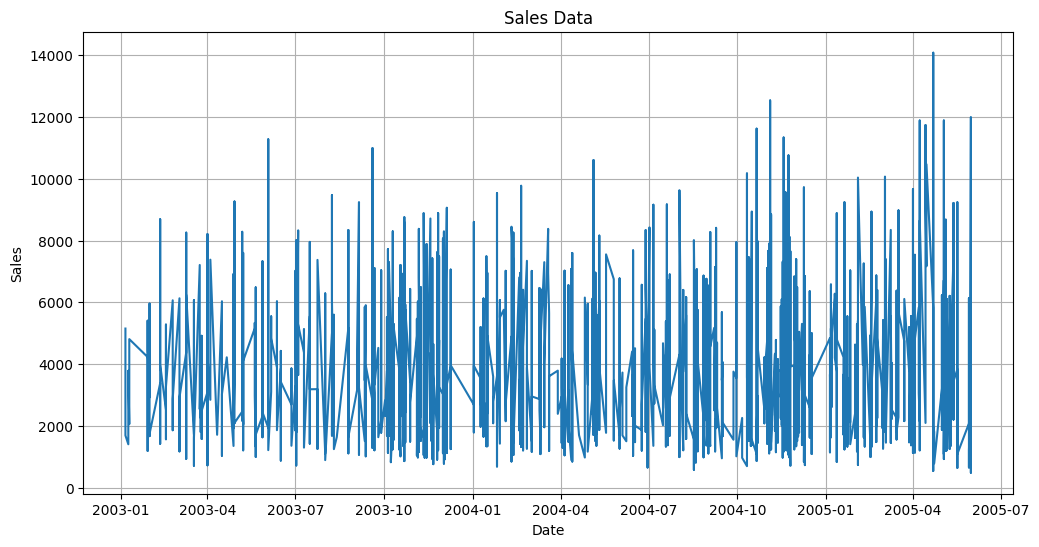

In [10]:
# Prophet requires columns named 'ds' (date) and 'y' (target variable)
# Modify these column mappings based on your actual column names
print("Available columns in your dataset:")
print(df.columns.tolist())

# Let the user select which columns to use
date_col = input("Enter the name of your date column: ")
sales_col = input("Enter the name of your sales column: ")

# Rename columns for Prophet
sales_df = df[[date_col, sales_col]].rename(columns={date_col: 'ds', sales_col: 'y'})

# Ensure date column is in datetime format
sales_df['ds'] = pd.to_datetime(sales_df['ds'])

# Sort by date
sales_df = sales_df.sort_values('ds')

# Check for and handle missing values
if sales_df.isnull().sum().sum() > 0:
    print(f"Found {sales_df.isnull().sum().sum()} missing values")
    # You can choose a strategy: interpolate, forward fill, or drop
    sales_df = sales_df.interpolate()  # Linear interpolation for missing values

# Display the processed DataFrame
print("\nProcessed data ready for Prophet:")
print(sales_df.head())

# Plot the raw data
plt.figure(figsize=(12, 6))
plt.plot(sales_df['ds'], sales_df['y'])
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Basic Statistics:
count     2823.000000
mean      3553.889072
std       1841.865106
min        482.130000
25%       2203.430000
50%       3184.800000
75%       4508.000000
max      14082.800000
Name: y, dtype: float64

Data frequency appears to be approximately 0 day(s)

Data frequency distribution:
ds
0.0     2571
1.0       94
2.0       37
3.0       24
4.0       23
5.0       16
6.0       20
7.0       16
8.0        8
9.0        3
10.0       1
11.0       3
12.0       3
19.0       2
24.0       1
Name: count, dtype: int64

Weekly Average Sales:
ds
2003-01-12    3042.964000
2003-01-19            NaN
2003-01-26            NaN
2003-02-02    3424.964138
2003-02-09            NaN
Freq: W-SUN, Name: y, dtype: float64

Monthly Average Sales:
ds
2003-01-31    3327.015385
2003-02-28    3435.029024
2003-03-31    3490.098000
2003-04-30    3476.026724
2003-05-31    3321.950172
Freq: ME, Name: y, dtype: float64


<ipython-input-11-42e56ac55a03>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_df.set_index('ds').resample('M')['y'].mean()


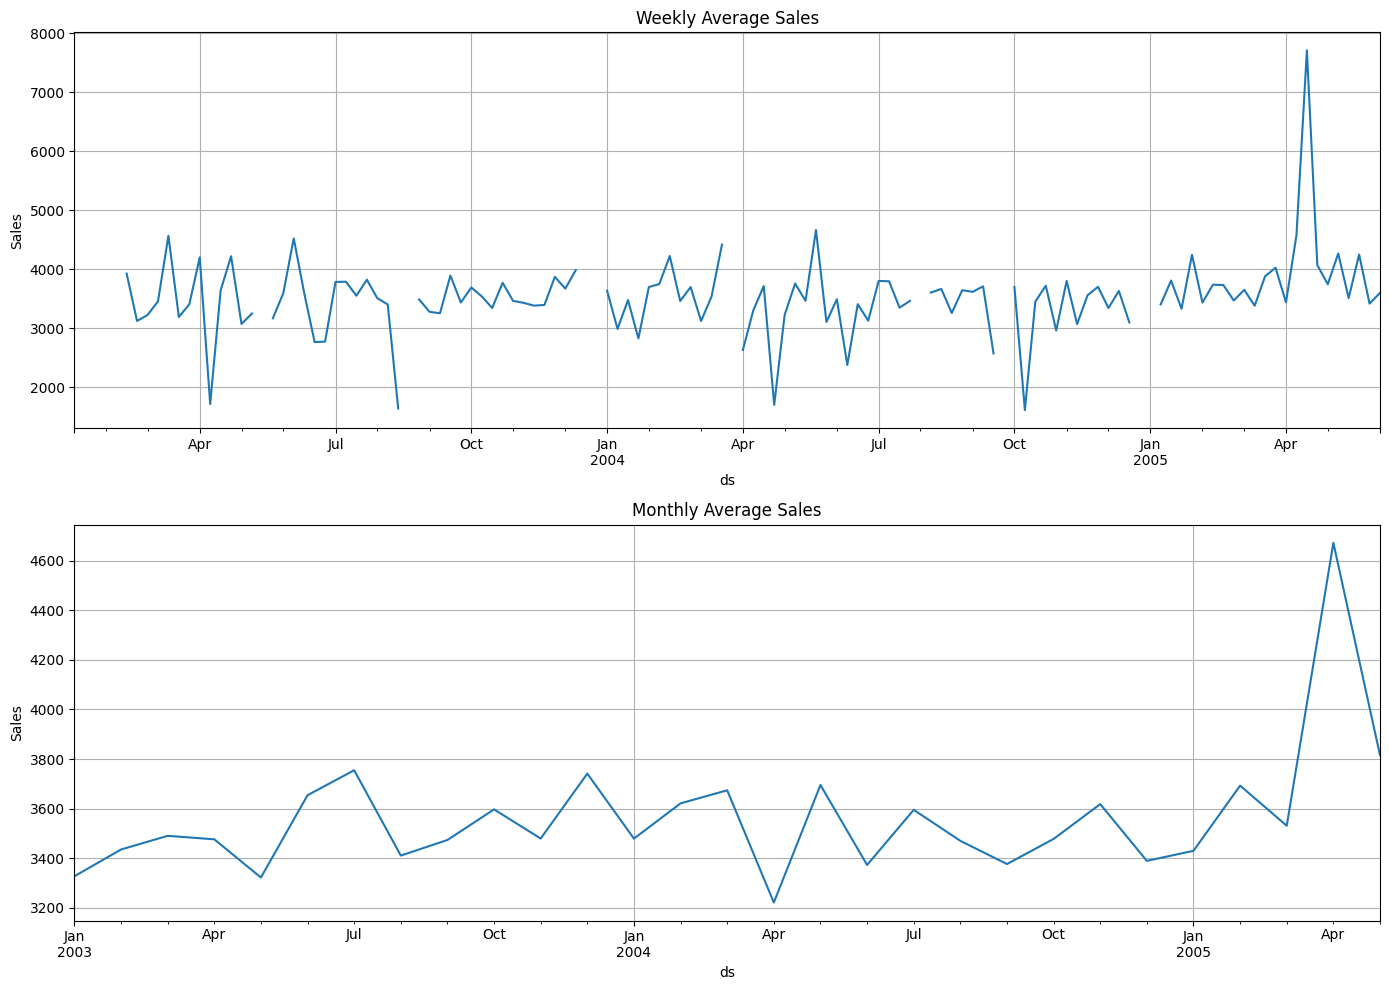

In [11]:
# Basic statistics
print("Basic Statistics:")
print(sales_df['y'].describe())

# Resample to see different time granularities
frequency = sales_df['ds'].diff().min().days
print(f"\nData frequency appears to be approximately {frequency} day(s)")

# Check time series frequency
print("\nData frequency distribution:")
time_diff = sales_df['ds'].diff().dt.days.value_counts().sort_index()
print(time_diff)

print("\nWeekly Average Sales:")
weekly_sales = sales_df.set_index('ds').resample('W')['y'].mean()
print(weekly_sales.head())

print("\nMonthly Average Sales:")
monthly_sales = sales_df.set_index('ds').resample('M')['y'].mean()
print(monthly_sales.head())

# Visualization of weekly and monthly trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Weekly trend
weekly_sales.plot(ax=ax1)
ax1.set_title('Weekly Average Sales')
ax1.set_ylabel('Sales')
ax1.grid(True)

# Monthly trend
monthly_sales.plot(ax=ax2)
ax2.set_title('Monthly Average Sales')
ax2.set_ylabel('Sales')
ax2.grid(True)

plt.tight_layout()
plt.show()

Training data: 2258 records from 2003-01-06 00:00:00 to 2004-12-02 00:00:00
Validation data: 565 records from 2004-12-02 00:00:00 to 2005-05-31 00:00:00


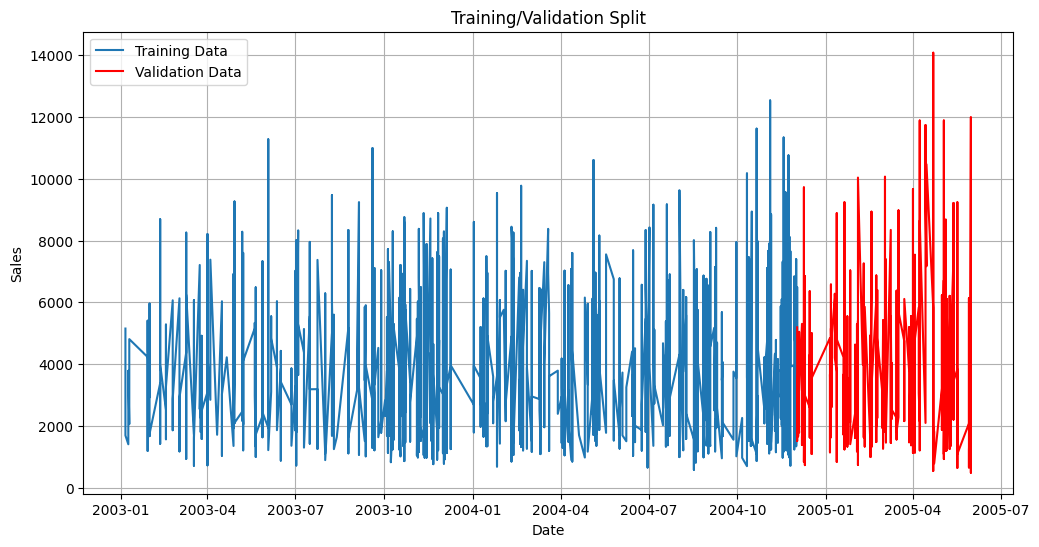

In [12]:
# Define training and validation periods - use the last X% as validation
validation_percentage = 20  # Use 20% of data for validation
split_idx = int(len(sales_df) * (100 - validation_percentage) / 100)

train_df = sales_df.iloc[:split_idx].copy()
valid_df = sales_df.iloc[split_idx:].copy()

print(f"Training data: {len(train_df)} records from {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"Validation data: {len(valid_df)} records from {valid_df['ds'].min()} to {valid_df['ds'].max()}")

# Plot the training/validation split
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Training Data')
plt.plot(valid_df['ds'], valid_df['y'], label='Validation Data', color='red')
plt.title('Training/Validation Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Initialize and train the Prophet model
model = Prophet(
    yearly_seasonality='auto',  # Automatically detect yearly seasonality
    weekly_seasonality='auto',  # Automatically detect weekly seasonality
    daily_seasonality=False,    # Set to True if you have hourly data
    seasonality_mode='multiplicative',  # Use multiplicative seasonality for retail sales
    changepoint_prior_scale=0.05        # Control flexibility of trend
)


# Fit the model
model.fit(train_df)

# Create future dataframe for predictions
# Include both validation period and future forecast
future_periods = len(valid_df) + 30  # validation period + 30 days forecast
future = model.make_future_dataframe(periods=future_periods, freq='D')

# Generate forecast
forecast = model.predict(future)

# Display forecast components
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r7dwpsz/dah2_q8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r7dwpsz/x83mv3du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74842', 'data', 'file=/tmp/tmp8r7dwpsz/dah2_q8o.json', 'init=/tmp/tmp8r7dwpsz/x83mv3du.json', 'output', 'file=/tmp/tmp8r7dwpsz/prophet_model87fay_0v/prophet_model-20250427161610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds         yhat   yhat_lower   yhat_upper
785 2006-07-16  3594.743053  1381.750803  5910.585094
786 2006-07-17  3590.999436  1409.934422  5870.566172
787 2006-07-18  3834.987720  1562.762902  6046.600992
788 2006-07-19  3553.235533  1454.802374  5921.197536
789 2006-07-20  3586.680564  1283.882873  5797.534228


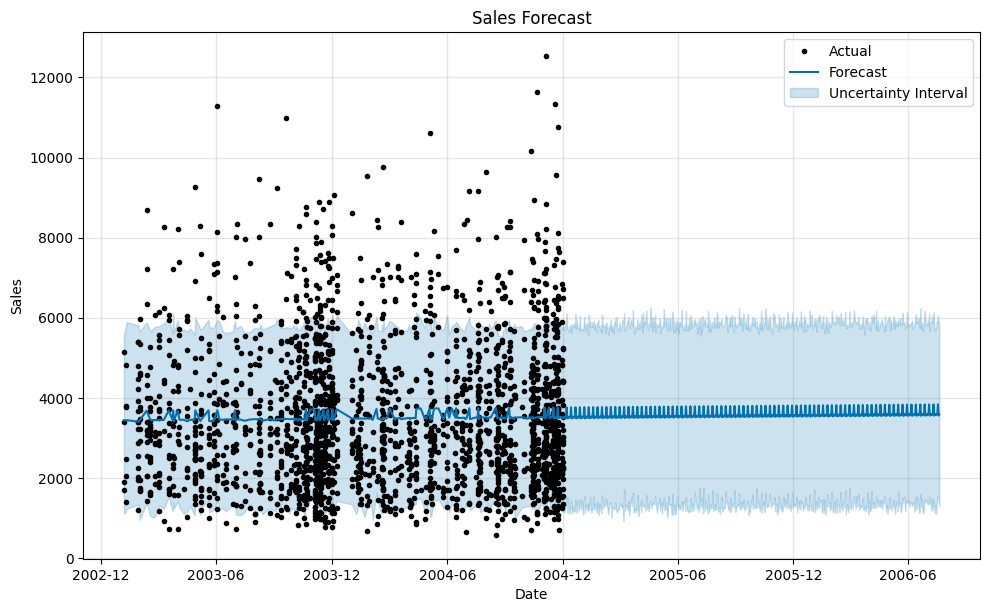

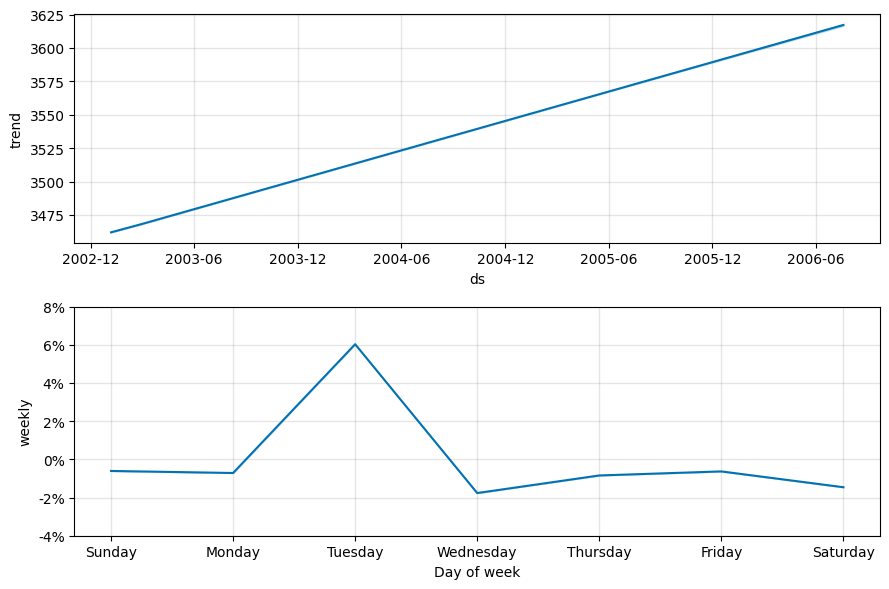

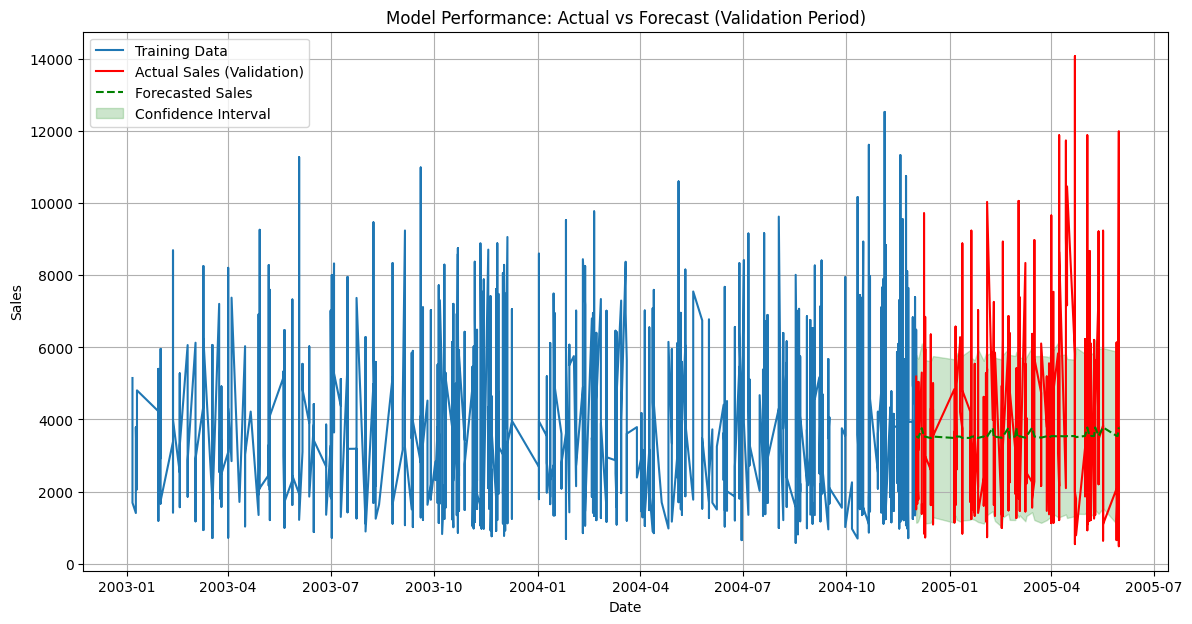

In [14]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual', 'Forecast', 'Uncertainty Interval'])
plt.grid(True)
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Plot actual vs forecasted for validation period
plt.figure(figsize=(14, 7))
plt.plot(train_df['ds'], train_df['y'], label='Training Data')
plt.plot(valid_df['ds'], valid_df['y'], label='Actual Sales (Validation)', color='red')

# Extract forecasted values for validation period
valid_forecast = forecast[forecast['ds'].isin(valid_df['ds'])]
plt.plot(valid_forecast['ds'], valid_forecast['yhat'], label='Forecasted Sales', color='green', linestyle='--')

# Add confidence intervals
plt.fill_between(valid_forecast['ds'],
                 valid_forecast['yhat_lower'],
                 valid_forecast['yhat_upper'],
                 color='green', alpha=0.2, label='Confidence Interval')

plt.title('Model Performance: Actual vs Forecast (Validation Period)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 1567.42
Root Mean Squared Error (RMSE): 2079.36
Mean Absolute Percentage Error (MAPE): 59.81%


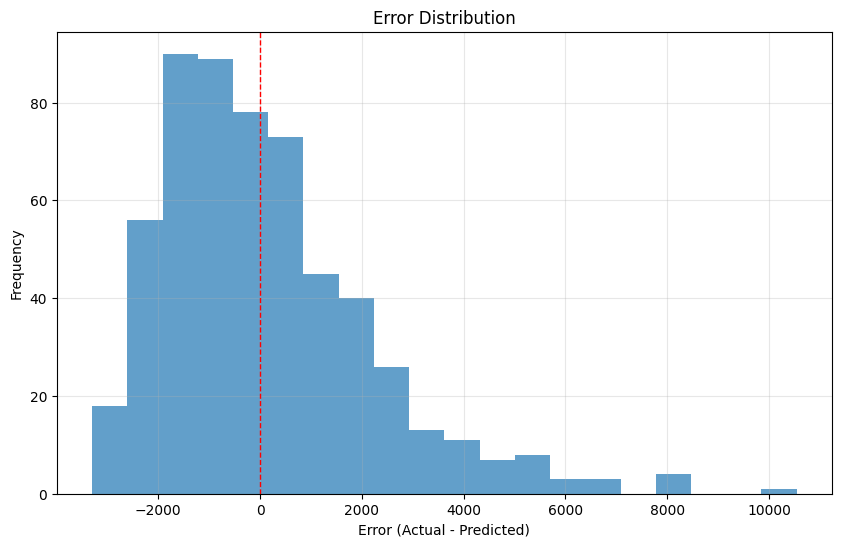

In [16]:
# Merge forecast and validation set on 'ds'
merged = pd.merge(valid_df, forecast[['ds', 'yhat']], on='ds', how='inner')

y_true = merged['y']
y_pred = merged['yhat']

# Now calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot error distribution
plt.figure(figsize=(10, 6))
errors = y_true - y_pred
plt.hist(errors, bins=20, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r7dwpsz/s83fxxd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r7dwpsz/15vr4isf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60341', 'data', 'file=/tmp/tmp8r7dwpsz/s83fxxd9.json', 'init=/tmp/tmp8r7dwpsz/15vr4isf.json', 'output', 'file=/tmp/tmp8r7dwpsz/prophet_model5z27493d/prophet_model-20250427162045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

Model Performance with Different Hyperparameters:
   prior_scale          mae         rmse       mape
0         0.01  1565.909637  2081.097240  59.446470
1         0.05  1567.419470  2079.358263  59.809393
2         0.10  1569.266859  2078.287454  60.129263
3         0.50  1598.679435  2074.190248  64.326659

✅ Best changepoint_prior_scale: 0.01


16:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


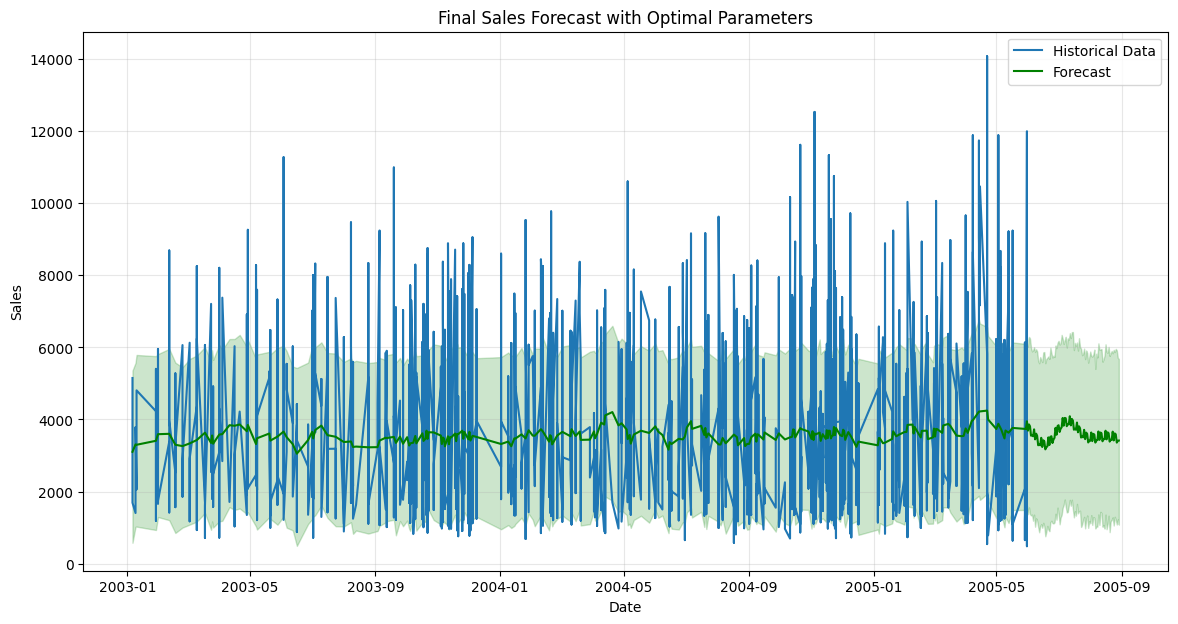


🎯 Final model and forecast saved as 'prophet_sales_model.pkl' and 'final_sales_forecast.csv'.


In [20]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Prepare
models = []
performances = []

# Test different changepoint_prior_scale values
changepoint_priors = [0.01, 0.05, 0.1, 0.5]

for prior in changepoint_priors:
    # Train model with current hyperparameters
    m = Prophet(
        yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=prior
    )
    m.fit(train_df)  # train_df must have columns: 'ds', 'y'

    # Generate future dates and forecast
    future_cv = m.make_future_dataframe(periods=len(valid_df))  # <-- 'm' not 'model'
    forecast_cv = m.predict(future_cv)

    # Merge forecast with validation set
    merged_cv = pd.merge(valid_df, forecast_cv[['ds', 'yhat']], on='ds', how='inner')

    y_true_cv = merged_cv['y'].values
    y_pred_cv = merged_cv['yhat'].values

    # Calculate error metrics
    mae_cv = mean_absolute_error(y_true_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
    mape_cv = np.mean(np.abs((y_true_cv - y_pred_cv) / y_true_cv)) * 100

    models.append(m)
    performances.append({
        'prior_scale': prior,
        'mae': mae_cv,
        'rmse': rmse_cv,
        'mape': mape_cv
    })

# Convert performance results to DataFrame
performance_df = pd.DataFrame(performances)
print("Model Performance with Different Hyperparameters:")
print(performance_df)

# Find the best model (lowest MAE)
best_idx = performance_df['mae'].idxmin()
best_prior = performance_df.loc[best_idx, 'prior_scale']
print(f"\n✅ Best changepoint_prior_scale: {best_prior}")

# Retrain best model on full data
final_model = Prophet(
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=best_prior
)
final_model.fit(sales_df)  # full dataset: must have 'ds', 'y'

# Create future dataframe (90 days forecast)
final_future = final_model.make_future_dataframe(periods=90)
final_forecast = final_model.predict(final_future)

# Plot final forecast
plt.figure(figsize=(14, 7))
plt.plot(sales_df['ds'], sales_df['y'], label='Historical Data')
plt.plot(final_forecast['ds'], final_forecast['yhat'], label='Forecast', color='green')
plt.fill_between(final_forecast['ds'],
                 final_forecast['yhat_lower'],
                 final_forecast['yhat_upper'],
                 color='green', alpha=0.2)
plt.title('Final Sales Forecast with Optimal Parameters')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save final model and forecast
with open('prophet_sales_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('final_sales_forecast.csv', index=False)

print("\n🎯 Final model and forecast saved as 'prophet_sales_model.pkl' and 'final_sales_forecast.csv'.")
